<a href="https://colab.research.google.com/github/ZachPetroff/DataM-A_Project/blob/main/Nearest_Neighbor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# This code can be used to add a folder in the repository to the Python import
# path, irrespective of whether the notebook is being run in colab or Jupyter.
# (C) 2020 Abe Leite, Indiana University Bloomington
# This code block is released under MIT license. Feel free to make use of
# this code in any projects so long as you reproduce this text.

import os
import sys
import subprocess

repo_URL = 'https://github.com/ZachPetroff/DataM-A_Project'
repo_name = repo_URL.split('/')[-1]
code_folder = ''

try:
  repo_path = subprocess.check_output('git rev-parse --show-toplevel', shell=True).decode().strip()
except subprocess.CalledProcessError:
  os.system(f'git clone {repo_URL} --depth 1')
  repo_path = os.path.abspath(repo_name)

code_path = os.path.join(repo_path, code_folder)
sys.path.append(code_path)
print(f'Loading code from {code_path}')

Loading code from /content/DataM-A_Project/


In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random
import math
from Model_Evaluation import *

In [3]:
# mount drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Download both training and validation data into your google drive

training_data = pd.read_csv('/content/drive/My Drive/training_diabetes_data.csv')
validation_data = pd.read_csv('/content/drive/My Drive/validation_diabetes_data.csv')

In [5]:
training_data.head()

,Gender,Polyuria,Polydipsia,sudden.weight.loss,partial.paresis,class
0,1,0,1,0,0,1
1,1,0,0,0,1,1
2,1,1,0,0,0,1
3,1,0,0,1,0,1
4,1,1,1,0,0,1


In [59]:
class Nearest_Neighbor:
  def __init__(self, n, training_data, dist_method="euclid", weights=np.array([1,1,1,1,1])):
    self.n = n
    self.training_data = training_data
    self.dist_method = dist_method
    self.weights = weights
    self.saved_classifications = []
    self.saved_points = []

  def manhattan_dist(self, x, y):
    dist = 0
    for i in range(len(x)):
      dist += abs(x[i] - y[i])
    return dist

  def euclid_dist(self, x, y):
    x = np.array(x)
    y = np.array(y)
    for i in range(len(x)):
      x[i] = x[i] * self.weights[i]
      y[i] = y[i] * self.weights[i]
    return np.linalg.norm(x-y)

  def cosine_similarity(self, x, y):
    x = np.array(x)
    y = np.array(y)
    return 1 - np.dot(x, y)/(np.linalg.norm(x)*np.linalg.norm(y))

  def pearson(self, x, y):
    x = np.array(x)
    y = np.array(y)
    mean_x = 0
    mean_y = 0
    for entry in range(len(x)):
      mean_x += x[entry]
      mean_y += y[entry]
    mean_x = mean_x / len(x)
    mean_y = mean_y / len(y)

    numerator = 0
    x_sq = 0
    y_sq = 0
    for entry in range(len(x)):
      numerator += (x[entry] - mean_x) * (y[entry] * mean_y)
      x_sq += (x[entry] - mean_x) ** 2
      y_sq += (y[entry] - mean_y) ** 2

    return 1 - (numerator / ((x_sq * y_sq) ** .5))

  def classify(self, point, class_column):
    point = point.tolist()
    if point in self.saved_points:
      indx = self.saved_points.index(point)
      return self.saved_classifications[indx]
    neighbors_dist = []
    neighbors_class = []
    for data in range(len(training_data)):
      training_point = self.training_data.iloc[data, 0:class_column-1]
      
      if self.dist_method == "euclid":
        dist = self.euclid_dist(training_point, point)
      
      if self.dist_method == "manhattan":
        dist = self.manhattan_dist(training_point, point)

      if self.dist_method == "cosine":
        dist = self.cosine_similarity(training_point, point)

      if self.dist_method == "pearson":
        dist = self.pearson(training_point, point)
      
      if len(neighbors_dist) < self.n:
        neighbors_dist.append(dist)
        neighbors_class.append(training_data.iloc[data, class_column-1])
      
      if len(neighbors_dist) >= self.n:
        largest_dist = max(neighbors_dist)
        if largest_dist > dist:
          largest_indx = neighbors_dist.index(largest_dist)
          neighbors_dist[largest_indx] = dist
          neighbors_class[largest_indx] = training_data.iloc[data, class_column-1]

    
    classification = round(sum(neighbors_class)/self.n)
    self.saved_classifications.append(classification)
    self.saved_points.append(point)
    return classification

In [7]:
# get true classes
true_classes = validation_data.iloc[0:len(validation_data), 5].tolist()

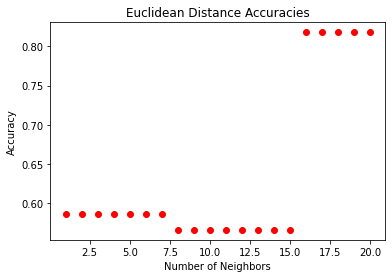

In [54]:
# Finding the best value of n

for n in range(20):
  nn = Nearest_Neighbor(n+1, training_data, weights=[1, 1, 1, 1, 1])
  predictions = []
  for i in range(len(validation_data)):
    classification = nn.classify(validation_data.iloc[i, 0:5], 6)
    predictions.append(classification)
  eval = Evaluation(true_classes, predictions)
  plt.plot(n+1, eval.accuracy(), "ro")

plt.title("Euclidean Distance Accuracies")
plt.xlabel("Number of Neighbors")
plt.ylabel("Accuracy")
plt.show()

# optimal n = 12 / accuracy = 90%

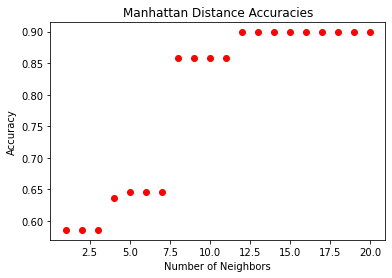

In [8]:
# Finding the best value of n
for n in range(20):
  nn = Nearest_Neighbor(n+1, training_data, dist_method="manhattan", weights=[1,1,1,1,1])
  predictions = []
  for i in range(len(validation_data)):
    classification = nn.classify(validation_data.iloc[i, 0:5], 6)
    predictions.append(classification)
  eval = Evaluation(true_classes, predictions)
  plt.plot(n+1, eval.accuracy(), "ro")

plt.title("Manhattan Distance Accuracies")
plt.xlabel("Number of Neighbors")
plt.ylabel("Accuracy")
plt.show()

# optimal n = 12 / accuracy = 63%

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in true_divide


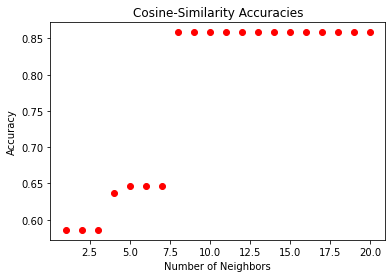

In [51]:
# Finding the best value of n

for n in range(20):
  nn = Nearest_Neighbor(n+1, training_data, dist_method="cosine")
  predictions = []
  for i in range(len(validation_data)):
    classification = nn.classify(validation_data.iloc[i, 0:5], 6)
    predictions.append(classification)
  eval = Evaluation(true_classes, predictions)
  plt.plot(n+1, eval.accuracy(), "ro")

plt.title("Cosine-Similarity Accuracies")
plt.xlabel("Number of Neighbors")
plt.ylabel("Accuracy")
plt.show()

# optimal n = 12 / accuracy = 90%

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in double_scalars
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in double_scalars


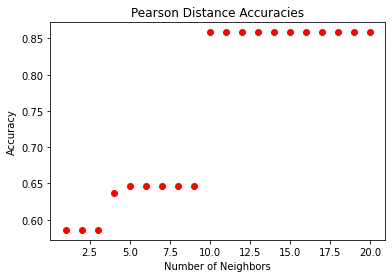

In [61]:
# Finding the best value of n

for n in range(20):
  nn = Nearest_Neighbor(n+1, training_data, dist_method="pearson")
  predictions = []
  for i in range(len(validation_data)):
    classification = nn.classify(validation_data.iloc[i, 0:5], 6)
    predictions.append(classification)
  eval = Evaluation(true_classes, predictions)
  plt.plot(n+1, eval.accuracy(), "ro")

plt.title("Pearson Distance Accuracies")
plt.xlabel("Number of Neighbors")
plt.ylabel("Accuracy")
plt.show()

# optimal n = 12 / accuracy = 90%

In [ ]:
# get predictions 
predictions = []
nn = Nearest_Neighbor(12, training_data)
for i in range(len(validation_data)):
  classification = nn.classify(validation_data.iloc[i, 0:5], 6)
  predictions.append(classification)

eval = Evaluation(true_classes, predictions)

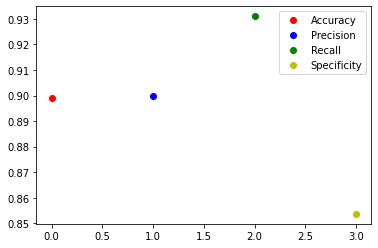

In [ ]:
eval.plot_metrics()

In [62]:
positives = 0
negatives = 0
for data in range(len(training_data)):
  if training_data.iloc[data,5] == 0:
    negatives += 1
  if training_data.iloc[data,5] == 1:
    positives += 1

pos_perc = positives / (negatives + positives)
neg_perc = negatives / (negatives + positives)

print("Percent of Positive Data: {}%".format(round(pos_perc,2)*100), "\nPercent of Negative Data: {}%".format(round(neg_perc,2)*100))

Percent of Positive Data: 62.0% 
Percent of Negative Data: 38.0%


In [63]:
SEED = 5
np.random.seed(SEED)

drop_indexes = []

for data in range(len(training_data)):
  r = np.random.uniform()
  if training_data.iloc[data,5] == 1:
    if .4 > r:
      drop_indexes.append(data)

print(len(drop_indexes))

training_data = training_data.drop(drop_indexes)

108


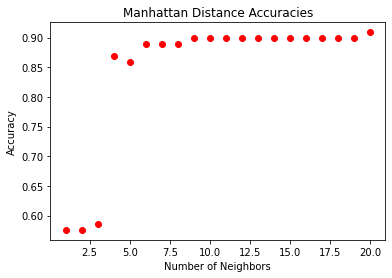

In [64]:
for n in range(20):
  nn = Nearest_Neighbor(n+1, training_data, weights=[1,1,1,1,1], dist_method="manhattan")
  predictions = []
  for i in range(len(validation_data)):
    classification = nn.classify(validation_data.iloc[i, 0:5], 6)
    predictions.append(classification)
  eval = Evaluation(true_classes, predictions)
  plt.plot(n+1, eval.accuracy(), "ro")

plt.title("Manhattan Distance Accuracies")
plt.xlabel("Number of Neighbors")
plt.ylabel("Accuracy")
plt.show()

In [ ]:
# get predictions 
predictions = []
nn = Nearest_Neighbor(20, training_data)
for i in range(len(validation_data)):
  classification = nn.classify(validation_data.iloc[i, 0:5], 6)
  predictions.append(classification)

eval = Evaluation(true_classes, predictions)

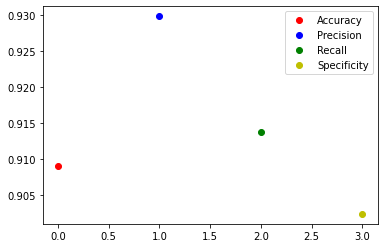

In [ ]:
eval.plot_metrics()